<a href="https://colab.research.google.com/github/RifdaKhairunnisa/RifdaKhairunnisa/blob/main/Rifda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Karakter Tulisan Tangan EMNIST dengan HOG Feature Extraction dan SVM



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


gpu_available = False
try:
    import cupy as cp
    import cudf
    from cuml.svm import SVC as cuSVC
    from cuml.model_selection import train_test_split as cu_train_test_split
    gpu_available = True
except Exception as e:
    gpu_available = False

print("Libraries berhasil diimport.")

Libraries berhasil diimport.


In [5]:

DATASET_DIR = Path("Dataset")
TRAIN_CSV = DATASET_DIR / "/content/drive/MyDrive/ATS/Dataset/emnist-letters-train.csv"
MAPPING_FILE = DATASET_DIR / "/content/drive/MyDrive/ATS/Dataset/emnist-letters-mapping.txt"

if not TRAIN_CSV.exists():
	raise FileNotFoundError(f"Dataset file not found: {TRAIN_CSV}")
if not MAPPING_FILE.exists():
	raise FileNotFoundError(f"Mapping file not found: {MAPPING_FILE}")

print(f"Dataset ditemukan: {TRAIN_CSV}")
print(f"Mapping file ditemukan: {MAPPING_FILE}")

Dataset ditemukan: /content/drive/MyDrive/ATS/Dataset/emnist-letters-train.csv
Mapping file ditemukan: /content/drive/MyDrive/ATS/Dataset/emnist-letters-mapping.txt


In [6]:

def load_emnist_letters_from_csv(csv_path: Path):
	"""Load EMNIST Letters dataset from CSV file."""
	df = pd.read_csv(csv_path, header=None)
	labels = df.iloc[:, 0].values.astype(np.int64) - 1
	images_flat = df.iloc[:, 1:].values.astype(np.uint8)
	images = images_flat.reshape(-1, 28, 28)
	images = np.transpose(images, (0, 2, 1))
	images = np.flip(images, axis=2)
	return images, labels

print("Memuat dataset...")
X_all, y_all = load_emnist_letters_from_csv(TRAIN_CSV)
print(f"Dataset berhasil dimuat: {X_all.shape[0]:,} sampel")
print(f"Ukuran gambar: {X_all[0].shape}")
print(f"Range label: {y_all.min()} hingga {y_all.max()} (A-Z)")

Memuat dataset...
Dataset berhasil dimuat: 88,800 sampel
Ukuran gambar: (28, 28)
Range label: 0 hingga 25 (A-Z)



Visualisasi sampel dataset...


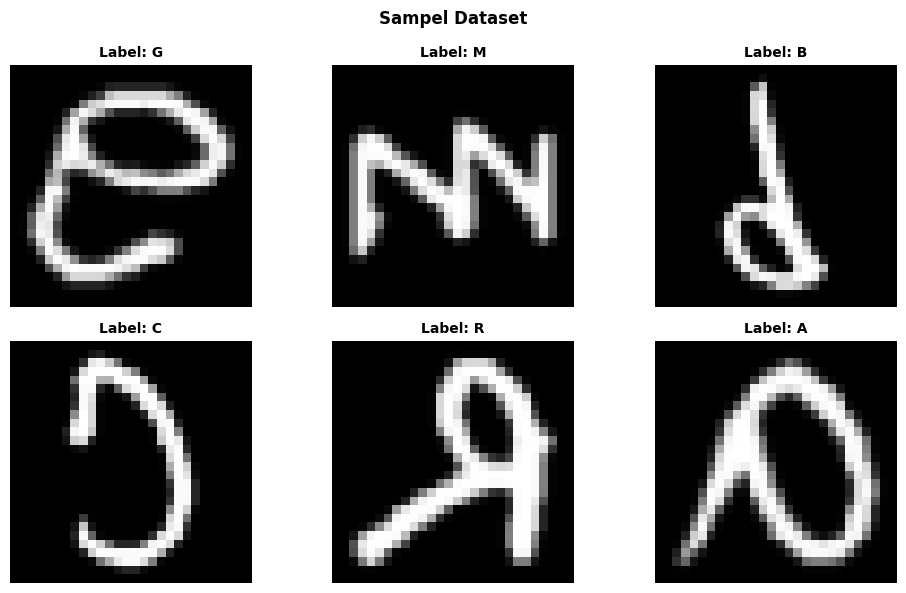

In [7]:

print("\nVisualisasi sampel dataset...")

NUM_CLASSES = 26
SAMPLES_PER_CLASS = 500

np.random.seed(42)
sample_indices = np.random.choice(len(X_all), size=min(6, len(X_all)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    img = X_all[sample_idx]
    label = chr(y_all[sample_idx] + ord('A'))

    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'Label: {label}', fontsize=10, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Sampel Dataset', fontsize=12, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [8]:
from collections import defaultdict
def build_balanced_subset(images: np.ndarray, labels: np.ndarray,
						   per_class: int = SAMPLES_PER_CLASS,
						   random_state: int = 42):
	rng = np.random.default_rng(random_state)
	indices_by_class = defaultdict(list)
	for idx, lab in enumerate(labels):
		indices_by_class[int(lab)].append(idx)

	selected_indices = []
	for lab in range(NUM_CLASSES):
		candidates = indices_by_class[lab]
		if len(candidates) < per_class:
			raise ValueError(f"Class {lab} has only {len(candidates)} samples")
		selected = rng.choice(candidates, size=per_class, replace=False)
		selected_indices.extend(selected.tolist())

	selected_indices = np.array(selected_indices)
	rng.shuffle(selected_indices)
	return images[selected_indices], labels[selected_indices]

print("\nMembuat balanced subset...")
X, y = build_balanced_subset(X_all, y_all)
print(f"Subset berhasil dibuat: {X.shape[0]:,} sampel")
print(f"Distribusi: {SAMPLES_PER_CLASS} sampel per kelas ({NUM_CLASSES} kelas)")


Membuat balanced subset...
Subset berhasil dibuat: 13,000 sampel
Distribusi: 500 sampel per kelas (26 kelas)



Menampilkan sampel dari setiap kelas...


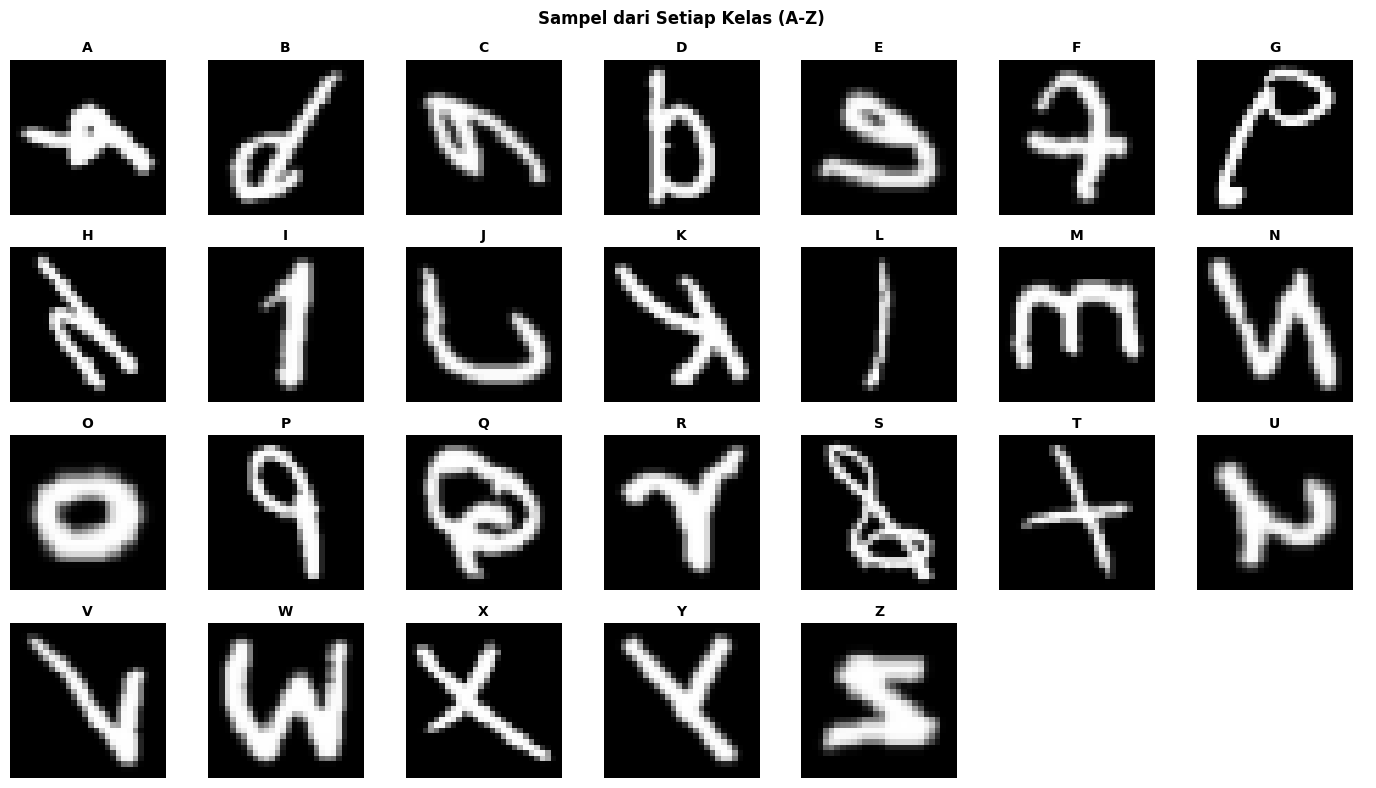

In [9]:

print("\nMenampilkan sampel dari setiap kelas...")

fig, axes = plt.subplots(4, 7, figsize=(14, 8))
axes = axes.flatten()

for class_idx in range(NUM_CLASSES):
    class_mask = y == class_idx
    class_indices = np.where(class_mask)[0]
    if len(class_indices) > 0:
        sample_idx = class_indices[0]
        img = X[sample_idx]
        label = chr(class_idx + ord('A'))

        axes[class_idx].imshow(img, cmap='gray')
        axes[class_idx].set_title(f'{label}', fontsize=10, fontweight='bold')
        axes[class_idx].axis('off')

# Hide extra subplots
for idx in range(NUM_CLASSES, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Sampel dari Setiap Kelas (A-Z)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:

from skimage.feature import hog

HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
HOG_BLOCK_NORM = "L2-Hys"

def compute_hog_features(images: np.ndarray):
	"""Ekstrak fitur HOG dari setiap gambar."""
	features = []
	for img in tqdm(images, desc="Ekstraksi fitur HOG"):
		feat = hog(img / 255.0,
				 orientations=HOG_ORIENTATIONS,
				 pixels_per_cell=HOG_PIXELS_PER_CELL,
				 cells_per_block=HOG_CELLS_PER_BLOCK,
				 block_norm=HOG_BLOCK_NORM,
				 visualize=False,
				 feature_vector=True)
		features.append(feat)
	return np.asarray(features, dtype=np.float32)

print("\nMemulai ekstraksi fitur HOG...")
print(f"Parameter HOG: orientations={HOG_ORIENTATIONS}, pixels_per_cell={HOG_PIXELS_PER_CELL}, cells_per_block={HOG_CELLS_PER_BLOCK}")
X_hog = compute_hog_features(X)
print(f"Ekstraksi HOG selesai. Dimensi fitur: {X_hog.shape}")


Memulai ekstraksi fitur HOG...
Parameter HOG: orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)


Ekstraksi fitur HOG: 100%|██████████| 13000/13000 [00:05<00:00, 2228.15it/s]

Ekstraksi HOG selesai. Dimensi fitur: (13000, 144)



Setup classifier SVM...
Konfigurasi: C=1, kernel=rbf, gamma=auto

Evaluasi model dengan metode LOOCV...
Dataset: 13,000 sampel
Validasi: 13,000 fold (setiap sampel divalidasi sekali)

Hasil evaluasi:
Accuracy  : 0.6946
Precision : 0.7057
Recall    : 0.6946
F1-Score  : 0.6918


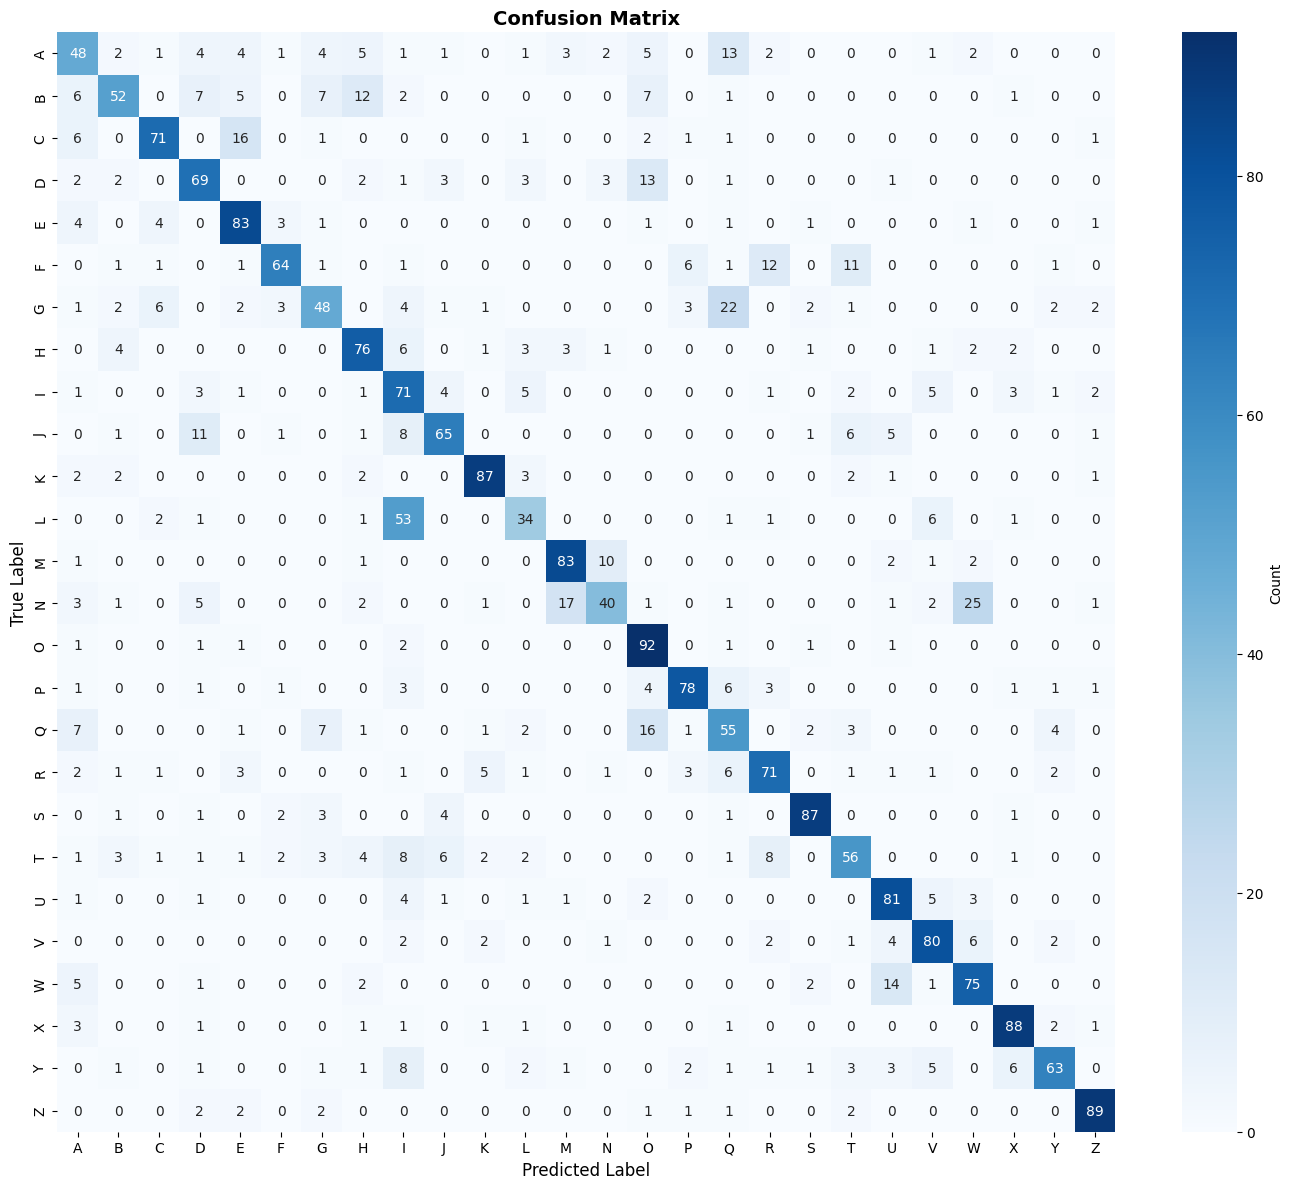

In [11]:

from sklearn.model_selection import LeaveOneOut, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

C_VALUE = 1
KERNEL_TYPE = 'rbf'
GAMMA_VALUE = 'auto'

print("\nSetup classifier SVM...")
print(f"Konfigurasi: C={C_VALUE}, kernel={KERNEL_TYPE}, gamma={GAMMA_VALUE}")
print(f'\nEvaluasi model dengan metode LOOCV...')
print(f'Dataset: {len(y):,} sampel')
print(f'Validasi: {len(y):,} fold (setiap sampel divalidasi sekali)')

if gpu_available:
    X_hog_gpu = cp.asarray(X_hog).astype(cp.float32)
    y_gpu = cp.asarray(y).astype(cp.int32)
    svm_model = cuSVC(C=C_VALUE, kernel=KERNEL_TYPE, gamma=GAMMA_VALUE)
    X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = cu_train_test_split(X_hog_gpu, y_gpu, test_size=0.2, random_state=42, stratify=y_gpu)
    svm_model.fit(X_train_gpu, y_train_gpu)
    predictions_gpu = svm_model.predict(X_test_gpu)
    predictions = cp.asnumpy(predictions_gpu).astype(int)
    actual_labels = cp.asnumpy(y_test_gpu).astype(int)
else:
    from sklearn.svm import SVC
    svm_model = SVC(C=C_VALUE, kernel=KERNEL_TYPE, gamma=GAMMA_VALUE, random_state=42)
    loocv = LeaveOneOut()
    predictions = cross_val_predict(svm_model, X_hog, y, cv=loocv, n_jobs=-1)
    actual_labels = y

conf_matrix = confusion_matrix(actual_labels, predictions, labels=np.arange(NUM_CLASSES))
accuracy = accuracy_score(actual_labels, predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(actual_labels, predictions, labels=np.arange(NUM_CLASSES), average='macro', zero_division=0)

alphabet_labels = [chr(i + ord('A')) for i in range(NUM_CLASSES)]
precision_classes, recall_classes, f1_classes, _ = precision_recall_fscore_support(
	actual_labels, predictions, labels=np.arange(NUM_CLASSES), average=None, zero_division=0)

print(f"\nHasil evaluasi:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1_score:.4f}")

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d', xticklabels=alphabet_labels, yticklabels=alphabet_labels, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:

OUT_DIR = Path("/content/drive/MyDrive/ATS/Output")
OUT_DIR.mkdir(exist_ok=True, parents=True)

print("\nMenyimpan hasil ke file...")

metrics = {
	"accuracy": float(accuracy),
	"precision_macro": float(precision),
	"recall_macro": float(recall),
	"f1_macro": float(f1_score),
}
pd.DataFrame([metrics]).to_csv(OUT_DIR / "metrics_loocv.csv", index=False)
print(f"Saved: {OUT_DIR / 'metrics_loocv.csv'}")

per_class_metrics = pd.DataFrame({
	'Class': alphabet_labels,
	'Precision': precision_classes,
	'Recall': recall_classes,
	'F1_Score': f1_classes
})
per_class_metrics.to_csv(OUT_DIR / "metrics_per_class.csv", index=False)
print(f"Saved: {OUT_DIR / 'metrics_per_class.csv'}")

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, cmap="Blues", annot=True, fmt="d",
			xticklabels=alphabet_labels, yticklabels=alphabet_labels,
			cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig(OUT_DIR / "confusion_matrix_loocv.png", dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved: {OUT_DIR / 'confusion_matrix_loocv.png'}")


Menyimpan hasil ke file...
Saved: /content/drive/MyDrive/ATS/Output/metrics_loocv.csv
Saved: /content/drive/MyDrive/ATS/Output/metrics_per_class.csv
Saved: /content/drive/MyDrive/ATS/Output/confusion_matrix_loocv.png


In [14]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

print("\nTuning hyperparameter...")
TUNING_RATIO = 0.25
X_tuning, _, y_tuning, _ = train_test_split(X_hog, y, test_size=1-TUNING_RATIO, stratify=y, random_state=42)
print(f'Subset untuk tuning: {len(y_tuning):,} sampel')

svm_param_grid = {
    'C': [0.5, 1.0, 1.5, 3.0, 7.0, 15.0],
    'gamma': ['scale', 'auto', 0.0001, 0.005, 0.05],
    'kernel': ['rbf', 'linear', 'sigmoid']
}

print('Running GridSearchCV...')
grid_search = GridSearchCV(
    SVC(),
    svm_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
grid_search.fit(X_tuning, y_tuning)

print('\nTuning completed.')
print(f'Best params: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_:.4f}')


Tuning hyperparameter...
Subset untuk tuning: 3,250 sampel
Running GridSearchCV...

Tuning completed.
Best params: {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.8102
